In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt


sys.path.append('../')

from BGS import BGS
from HST import HST

from FileEmcee import FileEmcee
from EmceeRun import EmceeRun

from Plotter import Plotter
from PlotterHst import PlotterHst

from VMaxDensity import VmaxDensity
from VMaxDensityHst import VmaxDensityHst

from ZSchechterModel import ZSchechterModel
from NoZSchechterModel import NoZSchechterModel

from Fileh5 import Fileh5

# 3D-HST Leja et al.

In [2]:
hst = HST('3dhst_master.phot.v4.1.cat.lite.hdf5')

In [3]:
emcee_file = Fileh5(folder='emcee_runs/bin_tests_runs/HST', info_file='0.8_1.3')

In [4]:
emcee_run = EmceeRun(emcee_file)

Multiple files with that <info_file> 
 [(0, 'NozSchechter_50w_300step_0.8_1.3_double.h5'), (1, 'NozSchechter_70w_400step_0.8_1.3_double.h5'), (2, 'NozSchechter_50w_300step_0.8_1.3.h5')] 
 - Tell me the index of the file you want to analyse:  2


In [5]:
plotter_hst = PlotterHst(hst, emcee_run)

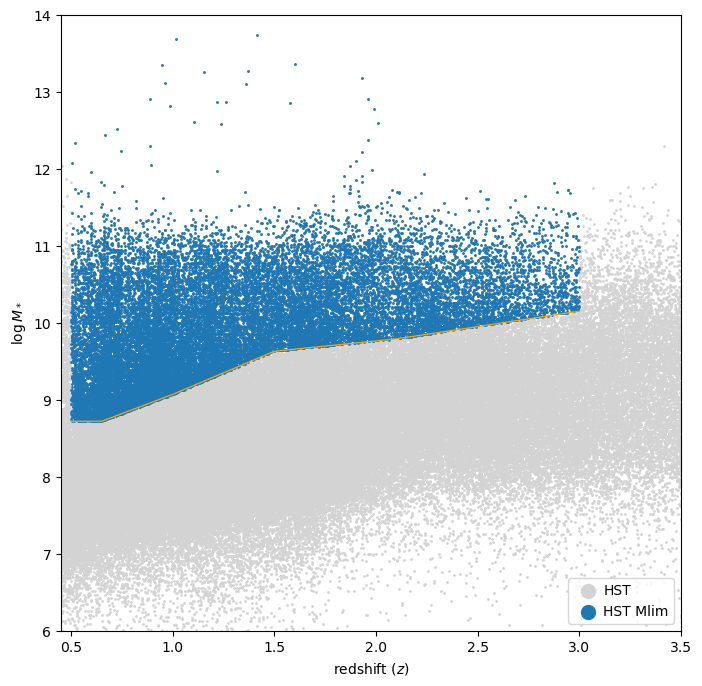

In [6]:
plt.figure(figsize=(8,8))
plotter_hst.plot_selected_data(0.5, 3.0)
# plotter_hst.plot_selected_data(0.5, 0.8)
# plt.plot(np.linspace(0.65, 3.0, 100), np.repeat(hst.mass_completeness_limit(3.0), 100))
# plt.plot(np.linspace(0.65, 3.0, 100), np.repeat(12, 100))

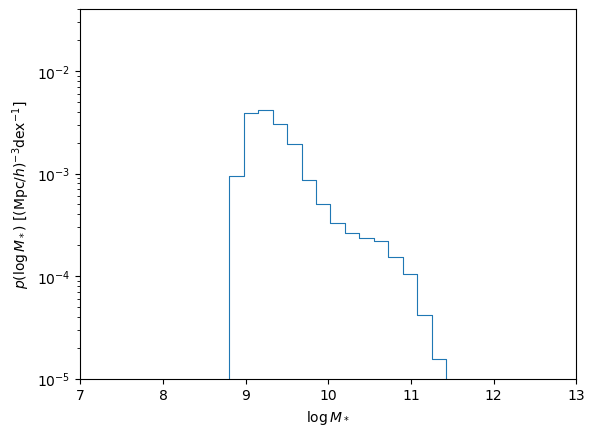

In [7]:
vmax_hst = VmaxDensityHst(hst.file)
h, b = vmax_hst.histogram_norm(0.8, 1.30)
PlotterHst.plot_vmax_hist(h, b, h, b)

In [8]:
z, x = hst.select_galaxies(0.8, 1.3)

In [9]:
def zmax_lim(mstar):
    y_values = [8.72, 8.72, 9.07, 9.63, 9.79, 10.15]
    x_values = [0.5, 0.65, 1.0, 1.5, 2.1, 3.0]

    f = interp1d(y_values, x_values)
    if mstar > y_values[-1]:
        return x_values[-1]
    else:
        return f(mstar)

In [10]:
from astropy.cosmology import Planck13
from scipy.interpolate import interp1d

v_zmin = Planck13.comoving_volume(0.5).value * Planck13.h ** 3 * 0.25 / 41253  # (Mpc/h)^3
# v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h ** 3 * self.footprint / self.sky  # (Mpc/h)^3
vmax = np.array([Planck13.comoving_volume(zmax_lim(m_i)).value * Planck13.h ** 3 * 0.25 / 41253 - v_zmin for m_i in x])


In [11]:
hist, bin_edges = np.histogram(x, bins=40, range=(6., 13.), weights=1/vmax)

(1e-05, 0.4)

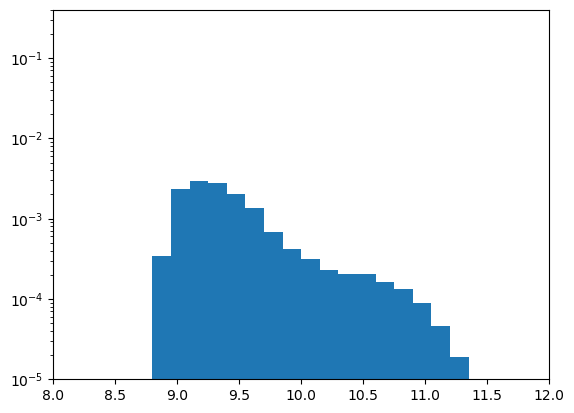

In [12]:
plt.hist(x, bins=40, range=(7., 13.), weights=1/vmax)
plt.yscale('log')
plt.xlim(8,12)
plt.ylim(1e-5, 4e-1)

In [13]:
vmax

array([1298832.44209967,  409332.49352361,  489164.76188249, ...,
       2121023.00944353,  565001.06490579, 2121023.00944353])

In [14]:
emcee_file_0508 = Fileh5(folder='emcee_runs/bin_tests_runs/HST', info_file='50w_300step_0.5_0.8')
emcee_file_0813 = Fileh5(folder='emcee_runs/bin_tests_runs/HST', info_file='50w_300step_0.8_1.3')
emcee_file_1319 = Fileh5(folder='emcee_runs/bin_tests_runs/HST', info_file='50w_300step_1.3_1.9')
emcee_file_1924 = Fileh5(folder='emcee_runs/bin_tests_runs/HST', info_file='50w_300step_1.9_2.4')
emcee_file_2430 = Fileh5(folder='emcee_runs/bin_tests_runs/HST', info_file='50w_300step_2.4_3.0')

emcee_run_0508 = EmceeRun(emcee_file_0508)
emcee_run_0813 = EmceeRun(emcee_file_0813)
emcee_run_1319 = EmceeRun(emcee_file_1319)
emcee_run_1924 = EmceeRun(emcee_file_1924)
emcee_run_2430 = EmceeRun(emcee_file_2430)

emcee_run_0508.set_best_params(discard=110)
emcee_run_0813.set_best_params(discard=110)
emcee_run_1319.set_best_params(discard=110)
emcee_run_1924.set_best_params(discard=110)
emcee_run_2430.set_best_params(discard=110)
emcee_runs = [emcee_run_0508, emcee_run_0813, emcee_run_1319, emcee_run_1924, emcee_run_2430]

best_params_0508 = emcee_run_0508.get_best_params()
best_params_0813 = emcee_run_0813.get_best_params()
best_params_1319 = emcee_run_1319.get_best_params()
best_params_1924 = emcee_run_1924.get_best_params()
best_params_2430 = emcee_run_2430.get_best_params()
best_params = [best_params_0508, best_params_0813, best_params_1319, best_params_1924, best_params_2430]

Multiple files with that <info_file> 
 [(0, 'NozSchechter_50w_300step_0.5_0.8.h5'), (1, 'NozSchechter_50w_300step_0.5_0.8_double.h5')] 
 - Tell me the index of the file you want to analyse:  0
Multiple files with that <info_file> 
 [(0, 'NozSchechter_50w_300step_0.8_1.3_double.h5'), (1, 'NozSchechter_50w_300step_0.8_1.3.h5')] 
 - Tell me the index of the file you want to analyse:  1
Multiple files with that <info_file> 
 [(0, 'NozSchechter_50w_300step_1.3_1.9.h5'), (1, 'NozSchechter_50w_300step_1.3_1.9_double.h5')] 
 - Tell me the index of the file you want to analyse:  0
Multiple files with that <info_file> 
 [(0, 'NozSchechter_50w_300step_1.9_2.4.h5'), (1, 'NozSchechter_50w_300step_1.9_2.4_double.h5')] 
 - Tell me the index of the file you want to analyse:  0
Multiple files with that <info_file> 
 [(0, 'NozSchechter_50w_300step_2.4_3.0_double.h5'), (1, 'NozSchechter_50w_300step_2.4_3.0.h5')] 
 - Tell me the index of the file you want to analyse:  1


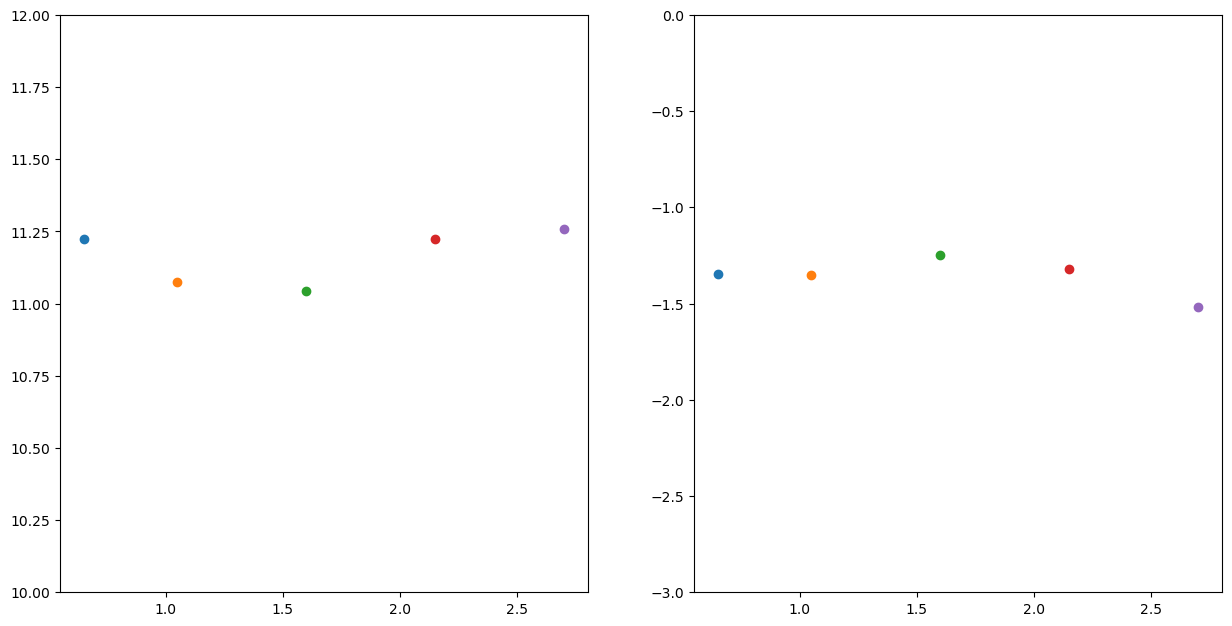

In [15]:
plt.figure(figsize=(15,7.5))

z_i = np.array([0.65, 1.05, 1.6, 2.15, 2.7])

plt.subplot(1,2,1)
for zii, best_i in zip(z_i, best_params):
    plt.plot(zii, best_i[0], 'o')
    plt.ylim(10, 12)

plt.subplot(1,2,2)
for zii, best_i in zip(z_i, best_params):
    plt.plot(zii, best_i[1], 'o')
    plt.ylim(-3, 0)

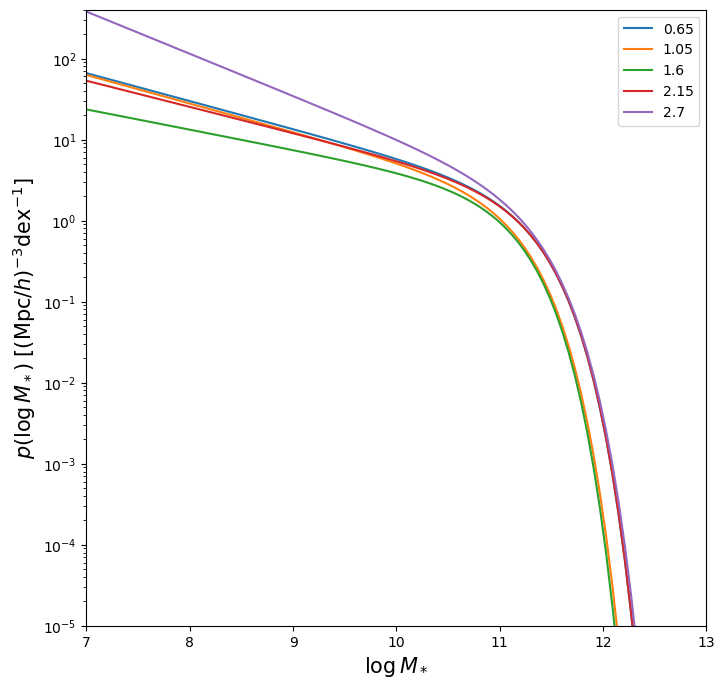

In [16]:
plt.figure(figsize=(8,8))
for zii, best_i in zip(z_i, best_params):
    PlotterHst.plot_NoZschechter(np.linspace(7,13, 100),best_i, **{'label':f'{zii}'})

plt.legend()

In [17]:
emcee_file_0508_dl = Fileh5(folder='emcee_runs/bin_tests_runs/HST', info_file='70w_400step_0.5_0.8_double')
emcee_file_0813_dl = Fileh5(folder='emcee_runs/bin_tests_runs/HST', info_file='70w_400step_0.8_1.3_double')
emcee_file_1319_dl = Fileh5(folder='emcee_runs/bin_tests_runs/HST', info_file='70w_400step_1.3_1.9_double')
emcee_file_1924_dl = Fileh5(folder='emcee_runs/bin_tests_runs/HST', info_file='70w_400step_1.9_2.4_double')
emcee_file_2430_dl = Fileh5(folder='emcee_runs/bin_tests_runs/HST', info_file='70w_400step_2.4_3.0_double')

emcee_run_0508_dl = EmceeRun(emcee_file_0508_dl)
emcee_run_0813_dl = EmceeRun(emcee_file_0813_dl)
emcee_run_1319_dl = EmceeRun(emcee_file_1319_dl)
emcee_run_1924_dl = EmceeRun(emcee_file_1924_dl)
emcee_run_2430_dl = EmceeRun(emcee_file_2430_dl)

emcee_run_0508_dl.set_best_params(discard=110)
emcee_run_0813_dl.set_best_params(discard=110)
emcee_run_1319_dl.set_best_params(discard=110)
emcee_run_1924_dl.set_best_params(discard=110)
emcee_run_2430_dl.set_best_params(discard=110)
emcee_runs_dl = [emcee_run_0508, emcee_run_0813, emcee_run_1319, emcee_run_1924, emcee_run_2430]

best_params_0508_dl = emcee_run_0508_dl.get_best_params()
best_params_0813_dl = emcee_run_0813_dl.get_best_params()
best_params_1319_dl = emcee_run_1319_dl.get_best_params()
best_params_1924_dl = emcee_run_1924_dl.get_best_params()
best_params_2430_dl = emcee_run_2430_dl.get_best_params()
best_params_dl = [best_params_0508_dl, best_params_0813_dl, best_params_1319_dl, best_params_1924_dl, best_params_2430_dl]

In [18]:
plotter_1319_dl = PlotterHst(hst, emcee_run_1319_dl)
plotter_1924_dl = PlotterHst(hst, emcee_run_1924_dl)
plotter_2430_dl = PlotterHst(hst, emcee_run_2430_dl)

In [19]:
# plotter_1319_dl.plot_emcee_samples3()

In [20]:
# plotter_1924_dl.plot_emcee_samples3()

In [21]:
# plotter_2430_dl.plot_emcee_samples3()

In [22]:
def logmZ(x, a, b, c):
    return a*x**2 + b*x + c

def alphaZ(x, a, b):
    return a*x + b

from scipy.optimize import curve_fit
popt_logm, _ = curve_fit(logmZ, np.array(z_i)[1:], np.array(best_params_dl)[:,0][1:])


popt_alpha1, _ = curve_fit(alphaZ, np.array(z_i), np.array(best_params_dl)[:,1])

popt_alpha2, _ = curve_fit(alphaZ, np.array(z_i), np.array(best_params_dl)[:,2])

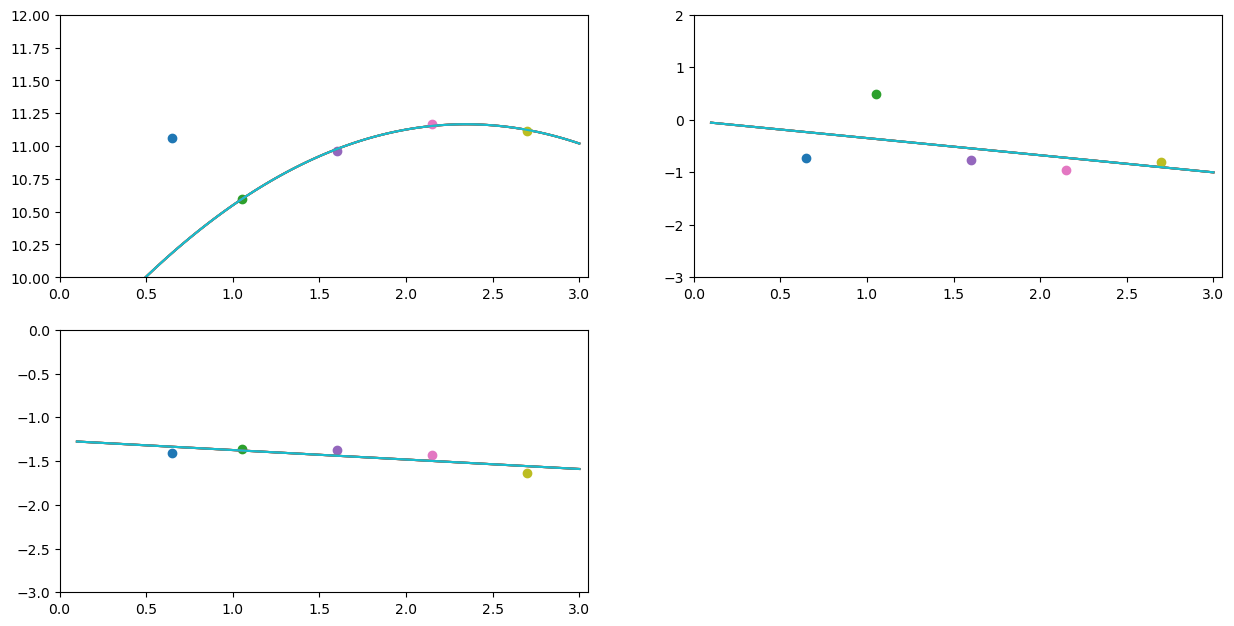

In [23]:
plt.figure(figsize=(15,7.5))

z_i = np.array([0.65, 1.05, 1.6, 2.15, 2.7])
logMpar = np.array([-1.83937458e-01,  3.40834292e+02, -3.31031442e+02])

plt.subplot(2,2,1)
for zii, best_i in zip(z_i, best_params_dl):
    plt.plot(zii, best_i[0], 'o')
    plt.plot(np.linspace(0.1, 3, 100), logmZ(np.linspace(0.1, 3, 100), popt_logm[0], popt_logm[1], popt_logm[2]))
    plt.xlim(0,3.05)
    plt.ylim(10, 12)

plt.subplot(2,2,2)
for zii, best_i in zip(z_i, best_params_dl):
    plt.plot(zii, best_i[1], 'o')
    plt.plot(np.linspace(0.1, 3, 100), alphaZ(np.linspace(0.1, 3, 100), popt_alpha1[0], popt_alpha1[1]))
    plt.xlim(0,3.05)
    plt.ylim(-3, 2)


plt.subplot(2,2,3)
for zii, best_i in zip(z_i, best_params_dl):
    plt.plot(zii, best_i[2], 'o')
    plt.plot(np.linspace(0.1, 3, 100), alphaZ(np.linspace(0.1, 3, 100), popt_alpha2[0], popt_alpha2[1]))
    plt.xlim(0,3.05)
    plt.ylim(-3, 0)

In [24]:
popt_logm, popt_alpha1, popt_alpha2

(array([-0.34141225,  1.60069288,  9.28971769]),
 array([-0.32639641, -0.02225241]),
 array([-0.1082214 , -1.26628651]))

In [25]:
file = Fileh5(folder='emcee_runs', info_file='ZDoubleSchechter_50w_700step')
emcee_run_hst = EmceeRun(file)

In [26]:
plotter_hst  = PlotterHst(hst, emcee_run_hst)

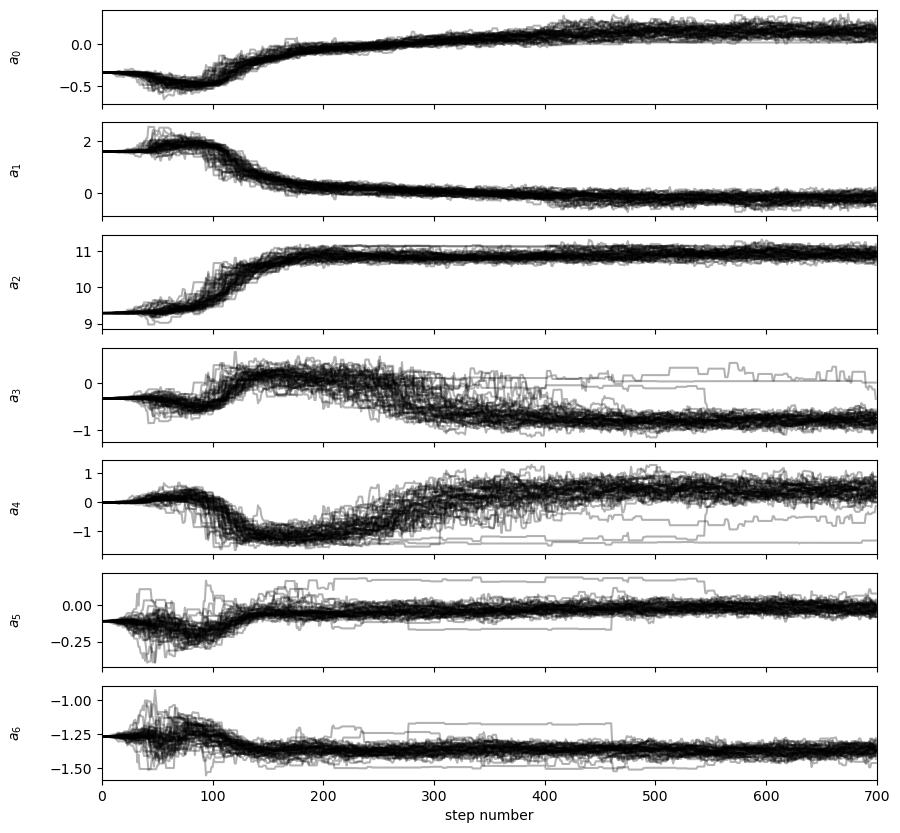

In [27]:
plotter_hst.plot_emcee_samplesZ()

In [30]:
emcee_run_hst.set_best_params(discard=350)

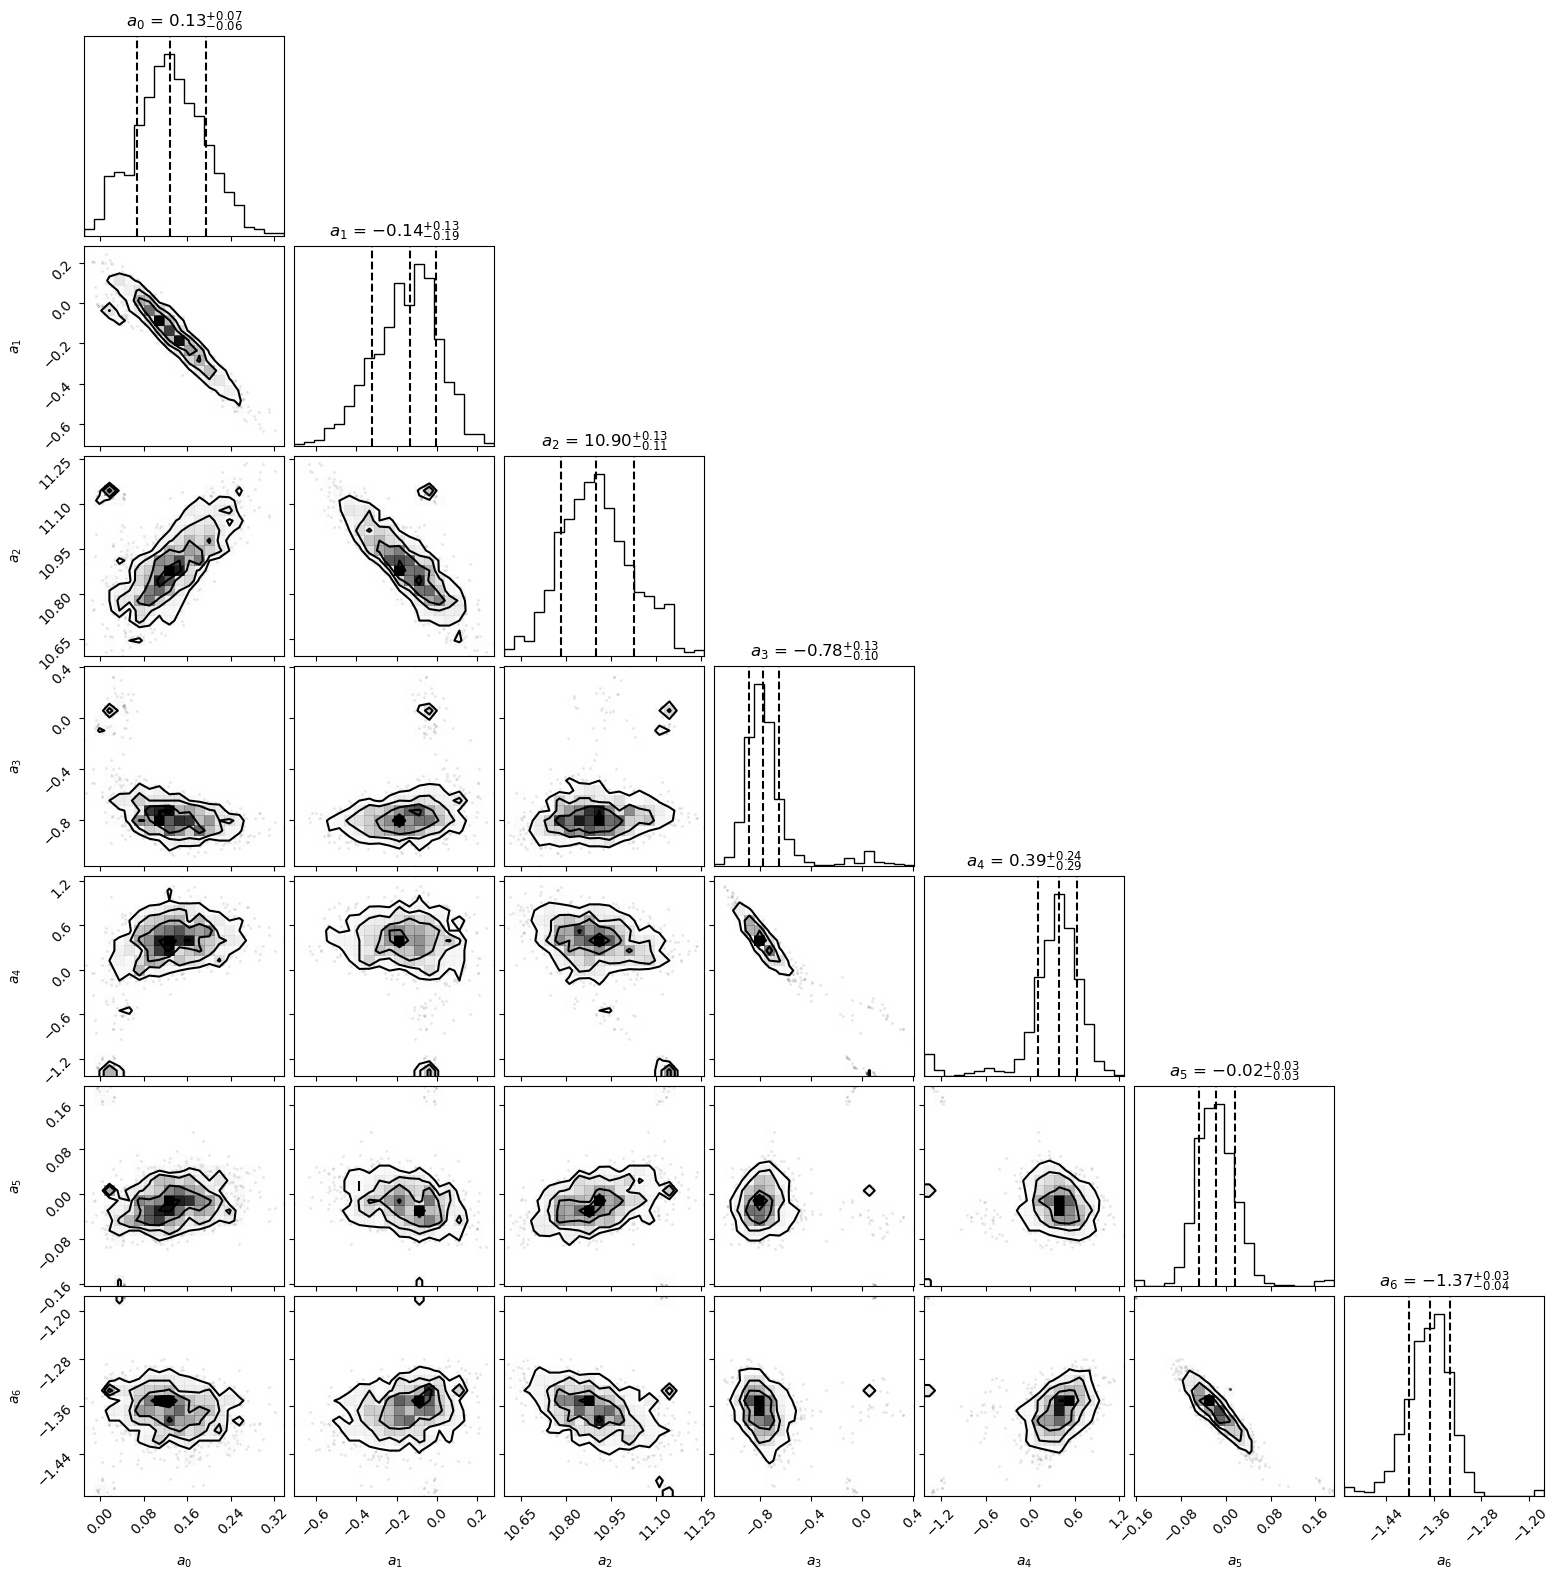

In [31]:
plotter_hst.plot_emcee_corner(emcee_run_hst.flat_samples, emcee_run_hst.labels6)

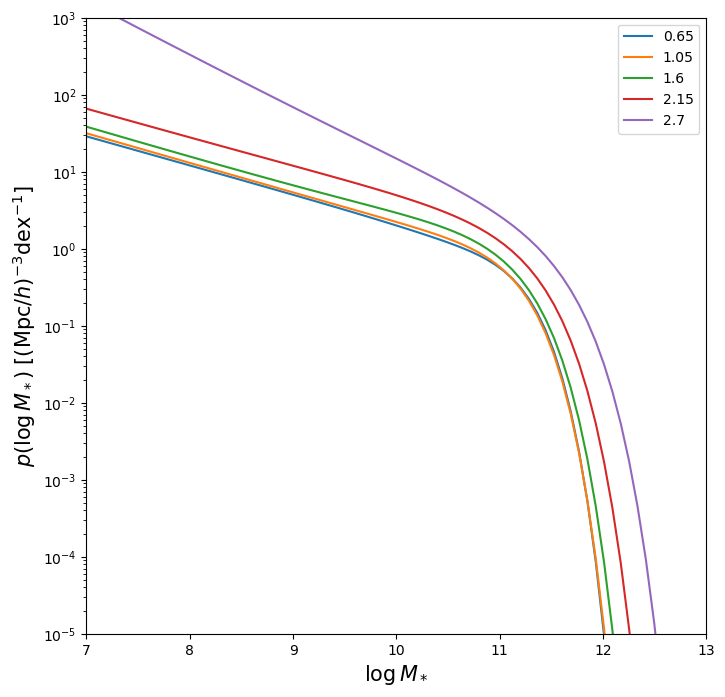

In [32]:
plt.figure(figsize=(8,8))
for zii in z_i:
    plotter_hst.plot_zschechter_double(np.linspace(7,15,100), zii, 1., emcee_run_hst.get_best_params(), **{'label':f'{zii}'})
    plt.ylim(1e-5, 1e3)
plt.legend()


In [ ]:
plt.figure(figsize=(8,8))
for zii, best_i in zip(z_i, best_params_dl):
    PlotterHst.plot_NoZschechter_double(np.linspace(7,13, 100),best_i, **{'label':f'{zii}'})

plt.legend()

In [ ]:
popt_alpha1, popt_alpha2

In [ ]:
# plotter_0508_dl = PlotterHst(hst, emcee_run_0508_dl)
# plotter_0813_dl = PlotterHst(hst, emcee_run_0813_dl)

In [ ]:
plotter_0508_dl.plot_emcee_samples3()

In [ ]:
plotter_0813_dl.plot_emcee_samples3()

In [ ]:
emcee_file_1924_dll = Fileh5(folder='emcee_runs/bin_tests_runs/HST', info_file='1.9_2.4_double')

In [ ]:
emcee_run_1924_dll = EmceeRun(emcee_file_1924_dll)

In [ ]:
plpl = PlotterHst(hst, emcee_run_1924_dll)

In [ ]:
plpl.plot_emcee_samples3()

In [ ]:
emcee_run_1924_dll.set_best_params(discard=50)

In [ ]:
plpl.plot_emcee_corner(emcee_run_1924_dll.flat_samples, emcee_run_1924_dll.labels3)

In [ ]:
plt.figure(figsize=(15, 7))
for i in range(5):

    plotter_hst.plot_emcee_corner(emcee_runs[i].flat_samples, emcee_runs[i].labels2)

In [ ]:
PlotterHst.plot_vmax_hist(h, b, h, b)

In [ ]:
plotter_hst.plot_emcee_samples2()

In [ ]:
emcee_run.set_best_params(discard=110)

In [ ]:
plotter_hst.plot_emcee_corner(emcee_run.flat_samples, emcee_run.labels2)

In [ ]:
plotter1319 = PlotterHst(hst, emcee_run_1319)
plotter1924 = PlotterHst(hst, emcee_run_1924)
plotter2430 = PlotterHst(hst, emcee_run_2430)

In [ ]:
plotter1319.plot_emcee_samples2()

In [ ]:
plotter1924.plot_emcee_samples2()

In [ ]:
plotter2430.plot_emcee_samples2()

In [ ]:
x_tot, z_tot = hst.x, hst.z
mask = (z_tot > 0.01) & (x_tot > 0.)
x, z = x_tot[mask], z_tot[mask]

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(z, x , 'o', markersize=0.5)

In [ ]:
cosmo = hst.cosmo

In [ ]:
dmin3 = cosmo.comoving_distance(0.01).value ** 3 
vmax = np.array([4 * np.pi / 3 * hst.footprint / hst.sky * (
                cosmo.comoving_distance(z_i).value ** 3 - dmin3) for z_i in z])

In [ ]:
vmax

In [ ]:
bgs = BGS('BGS_ANY_full.provabgs.lite.hdf5')

In [ ]:
import astropy.table as aTable
bgs_cat = aTable.Table.read('../data/BGS_ANY_full.provabgs.lite.hdf5')

In [ ]:
bgs_vmax = bgs_cat['Vmax']

In [ ]:
bgs_z = bgs_cat['Z_HP']

In [ ]:
bgs_vmax_calc = np.array([4 * np.pi / 3 * 14000 / hst.sky * (
                cosmo.comoving_distance(z_i).value ** 3 - dmin3) for z_i in bgs_z])

In [ ]:
bgs_vmax_calc

In [ ]:
bgs_vmax

In [ ]:
14000/hst.sky

In [ ]:
def vmax(x):
    dmin3 = self.cosmo.comoving_distance(0.65).value ** 3
    return np.array([4 * np.pi / 3 * self.footprint / self.sky * (
                self.cosmo.comoving_distance(self.zmax_lim(m_i)).value ** 3 - dmin3) for m_i in x])

In [ ]:
z, x = hst.select_galaxies(0.65, 3.0)

In [ ]:
vmax = hst.get_vmax(x)

In [ ]:
np.unique(vmax)

In [ ]:
np.unique(bgs.vmax[bgs.x_median > 10.15])

In [ ]:
hst.mass_completeness_limit(3.0)

In [ ]:
hst.x[hst.x>10.15].shape[0]/ hst.x.shape[0]

In [ ]:
x[x>10.15].shape[0]/x.shape[0]

In [ ]:
plt.plot(hst.z[hst.z > 0], hst.x[hst.z > 0], 'o', markersize=1)

In [ ]:
hst.get_number_galaxies(bin=True, zmin=0.65, zmax=0.69)

In [ ]:
z, x = hst.select_galaxies(0.65, 0.69)

In [ ]:
NoZSchechterModel.phi(x, 10., -0.2)

In [ ]:
z, x = hst.select_galaxies(0.65, 0.69)

In [ ]:
# plotter_hst.plot_emcee_samples()

In [ ]:
z, x = gathering_data(hst, 0.65, 3.0)

In [ ]:
z_lin = np.linspace(0.65, 3.0, 100)
plt.figure(figsize=(8,8))
plt.plot(z, x, 'o', markersize=1)
plt.plot(z_lin, mass_completeness_limit(z_lin))
plt.xlabel(r"redshift ($z$)")
plt.ylabel(r"$\log M_*$")
# plt.xlim(0.5, 3.5)
plt.ylim(8., 15)


In [ ]:
footprint = 0.25 #deg^2

cosmo = FlatLambdaCDM(H0=67.8, Om0=0.307)

dmin3 = cosmo.comoving_distance(0.65).value ** 3
vmax = np.array([4*np.pi/3 * 0.25/41253 * (cosmo.comoving_distance(zmax(m_i)).value ** 3 - dmin3) for m_i in x])

In [ ]:
x_lin = np.linspace(x.min(), x.max(), 100)
for i in range(x_lin.shape[0]):
    plt.scatter(x_lin[i], zmax(x_lin[i]))

In [ ]:
vmax

In [ ]:
x_lin[10], zmax(x_lin[10])

In [ ]:
x_test = x[x<9.]
z_test = z[x<9]

In [ ]:
mass_completeness_limit(z_test[0])

In [ ]:
zmax(x_test[0])

In [ ]:
mass_completeness_limit(3.0)

In [ ]:
z_lin = np.linspace(0.65, 3.0, 100)
plt.figure(figsize=(8,8))
plt.plot(z_test, x_test, 'o', markersize=1)
plt.plot(z_lin, mass_completeness_limit(z_lin))
plt.xlabel(r"redshift ($z$)")
plt.ylabel(r"$\log M_*$")
# plt.xlim(0.5, 3.5)
plt.ylim(8., 15)


In [ ]:
cosmo.comoving_distance()

In [ ]:
write_table_hdf5(hst['lmass', 'z_peak'], '3dhst_master.phot.v4.1.cat.lite.hdf5', overwrite=True)

In [ ]:
x.shape

In [ ]:
lmass = hst['lmass']
# z_spec = hst['z_spec']
z_peak = hst['z_peak']

# mask_spec = (z_spec >= 0.)
mask_peak = (z_peak >= 0.) & (lmass > 0.)

In [ ]:
mass_complete = np.array(list(zip([0.65, 1.0, 1.5, 2.1, 3.0], [8.72, 9.07, 9.63, 9.79, 10.15])))

In [ ]:
mass_complete[:,0]


In [ ]:
hst['lmass','z_peak'].to_pandas().to_hdf('3dhst_master.phot.v4.1.cat.lite.hdf5', key='hst_lite', mode='w')

In [ ]:
# cosmos = h5py.File('../data/COSMOS2015_Laigle+_v1.1.lite.hdf5')

In [ ]:
cosmos = aTable.Table.read('../data/COSMOS2015_Laigle+_v1.1.lite.hdf5')

In [ ]:
# z, x = gathering_data(cosmos, 0.175, 4.4)

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(z, x, 'o', markersize=0.3)
plt.plot(np.linspace(0.175, 4.4, 100), mass_completeness_limit(np.linspace(0.175, 4.4, 100)))
# plt.plot(mass_complete_cosmos[:,0], mass_complete_cosmos[:,1])
# plt.plot(np.linspace(x_values[0],x_values[-1],100), mass_completeness_cosmos(np.linspace(x_values[0],x_values[-1],100)))

In [ ]:
z.shape

In [ ]:
z_cosmos = cosmos['ZPDF']
m_cosmos = cosmos['MASS_MED']
mask = (z_cosmos >= .175) & (z_cosmos <= 4.4) & (m_cosmos > 8.1)
z = z_cosmos[mask]
mask_lim = m_cosmos > mass_completeness_cosmos(z)
mstar = m_cosmos[mask_lim]
z = z_cosmos[mask_lim]

In [ ]:
mass_complete_cosmos = np.array(list(zip([0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4], 
                                         [8.1, 8.7, 9.1, 9.3, 9.7, 9.9, 10.0, 10.1, 10.1, 10.1])))

In [ ]:
x_values = [0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4]

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(z, x, 'o', markersize=1)
plt.plot(mass_complete_cosmos[:,0], mass_complete_cosmos[:,1])
plt.plot(np.linspace(x_values[0],x_values[-1],100), mass_completeness_cosmos(np.linspace(x_values[0],x_values[-1],100)))

plt.xlabel(r"redshift ($z$)")
plt.ylabel(r"$\log M_*$")
# plt.xlim(0.5, 3.5)
# plt.ylim(8., 15)

In [ ]:

x_values = [0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4]
y_values = [8.1, 8.7, 9.1, 9.3, 9.7, 9.9, 10.0, 10.1, 10.1, 10.1]

f = interp1d(x_values, y_values)

In [ ]:
f(1.3)

In [ ]:
def mass_completeness_cosmos(x):
    
    x_values = [0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4]
    y_values = [8.1, 8.7, 9.1, 9.3, 9.7, 9.9, 10.0, 10.1, 10.1,10.1]

    f = interp1d(x_values, y_values)
    return f(x)

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(z_cosmos[mask], m_cosmos[mask], 'o', markersize=1)
plt.plot(mass_complete_cosmos[:,0], mass_complete_cosmos[:,1])
plt.plot(np.linspace(x_values[0], x_values[-1], 100), mass_completeness_cosmos(np.linspace(x_values[0], x_values[-1], 100)))
plt.xlabel(r"redshift ($z$)")
plt.ylabel(r"$\log M_*$")
# plt.xlim(0.5, 3.5)
# plt.ylim(8., 15)
# plt.plot(np.linspace(1, 10, 100), mass_completeness_cosmos(np.linspace(1, 10, 100)))

# COSMOS2015 Laigle et al. 2016

In [ ]:
cosmos2015 = Table.read('../data/COSMOS2015_Laigle+_v1.1.fits')

In [ ]:
write_table_hdf5(cosmos2015['ZPDF', 'MASS_MED'], 'COSMOS2015_Laigle+_v1.1.lite.hdf5')

In [ ]:
cosmos2015[:5]

In [ ]:
mask_flag = (cosmos2015['FLAG_DEEP'] == 1)

In [ ]:
c = cosmos2015['ZPDF'][mask_flag]

In [ ]:
c[:5]

In [ ]:
z_cosmos = cosmos2015['ZPDF']
m_cosmos = cosmos2015['MASS_MED']
mask = (z_cosmos >= 0.) & (m_cosmos > 0.)

In [ ]:
mass_complete_cosmos = np.array(list(zip([0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4], 
                                         [8.1, 8.7, 9.1, 9.3, 9.7, 9.9, 10.0, 10.1, 10.1])))

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(z_cosmos[mask], m_cosmos[mask], 'o', markersize=1)
plt.plot(mass_complete_cosmos[:,0], mass_complete_cosmos[:,1])
plt.xlabel(r"redshift ($z$)")
plt.ylabel(r"$\log M_*$")
# plt.xlim(0.5, 3.5)
# plt.ylim(8., 15)


In [ ]:
cosmos2015['ZPDF', 'MASS_MED'].to_pandas().to_hdf('../data/COSMOS2015_Laigle+_v1.1.lite.hdf5', key='cosmos_lite', mode='w')